In [1]:
import pandas as pd
from plotnine import *
import numpy as np

In [2]:
or_events = pd.read_parquet('./outage_report_2019-20')

In [104]:
filtered_or_events = or_events[(or_events['vendor'] != '') & (or_events['vendor'] != 'overview')].reset_index(drop=True)
filtered_or_events.loc[filtered_or_events['status_code'] <= 2, 'status_code'] = 0
filtered_or_events = filtered_or_events.drop_duplicates(subset=['vendor', 'event_time', 'status_code'])
filtered_or_events = filtered_or_events.groupby(['vendor', 'event_time'])['status_code'].max().reset_index()

In [105]:
filtered_or_events['evtime'] = pd.to_datetime(filtered_or_events['event_time'], unit='s')

In [106]:
def proper_vendor_names(series):
    return series.str.capitalize().replace(['Apple-servers', 'Facebook-messenger', 'Youtube'], ['Apple', 'FB Msgr', 'YouTube'])

filtered_or_events['vendor_proper'] = proper_vendor_names(filtered_or_events['vendor'])

vendor_list = list(filtered_or_events.groupby('vendor_proper')['status_code'].sum().reset_index().rename(columns={'status_code':'count'}).sort_values('count')['vendor_proper'])

filtered_or_events['vendor_cat'] = pd.Categorical(filtered_or_events['vendor_proper'], ordered=True, categories=vendor_list)

In [6]:
facebook_reports = filtered_or_events[filtered_or_events['vendor'] == 'facebook'].reset_index(drop=True)

In [7]:
sorted_facebook_reports = facebook_reports.sort_values('event_time').reset_index(drop=True)

In [8]:
sorted_facebook_reports

,event_time,status_code,vendor,monitor,evtime,vendor_proper,vendor_cat
0,1.555241e+09,210.0,facebook,Outage Report,2019-04-14 11:20:00,Facebook,Facebook
1,1.555242e+09,299.0,facebook,Outage Report,2019-04-14 11:40:00,Facebook,Facebook
2,1.555243e+09,813.0,facebook,Outage Report,2019-04-14 12:00:00,Facebook,Facebook
3,1.555244e+09,874.0,facebook,Outage Report,2019-04-14 12:20:00,Facebook,Facebook
4,1.555246e+09,891.0,facebook,Outage Report,2019-04-14 12:40:00,Facebook,Facebook
...,...,...,...,...,...,...,...
43674,1.604180e+09,0.0,facebook,Outage Report,2020-10-31 21:40:00,Facebook,Facebook
43675,1.604182e+09,0.0,facebook,Outage Report,2020-10-31 22:00:00,Facebook,Facebook
43676,1.604183e+09,0.0,facebook,Outage Report,2020-10-31 22:20:00,Facebook,Facebook
43677,1.604184e+09,0.0,facebook,Outage Report,2020-10-31 22:40:00,Facebook,Facebook


In [ ]:
# An event has start, end, peak, median, mean

In [107]:
def extract_failures_from_reports(partial_df):
    event_start = None
    prev_event_time = None
    num_reports_list = []
    failure_events = []
    for _, report_event in partial_df.sort_values('event_time').iterrows():
        num_reports = report_event['status_code']
        event_time = report_event['event_time']

        if num_reports == 0:
            if event_start is not None:
                failure_events.append({
                    'start_time': event_start,
                    'end_time': prev_event_time,
                    'peak': np.max(num_reports_list),
                    'median': np.median(num_reports_list),
                    'mean': np.mean(num_reports_list)
                })
                event_start = None
                num_reports_list = []
        else:
            if event_start is None:
                event_start = event_time
                
            num_reports_list.append(num_reports)

        prev_event_time = event_time
    
    return pd.DataFrame(failure_events)

In [284]:
# Validate this later by plotting both the intervals and direct from reports.
# To check if the failure creation algorithm is correct
facebook_failures = extract_failures_from_reports(sorted_facebook_reports)
facebook_failures.sort_values('median')

,start_time,end_time,peak,median,mean
2053,1.564102e+09,1.564102e+09,3.0,3.0,3.000000
4601,1.582679e+09,1.582679e+09,3.0,3.0,3.000000
4600,1.582675e+09,1.582675e+09,3.0,3.0,3.000000
2433,1.565659e+09,1.565659e+09,3.0,3.0,3.000000
2434,1.565664e+09,1.565664e+09,3.0,3.0,3.000000
...,...,...,...,...,...
3965,1.574808e+09,1.574808e+09,215.0,215.0,215.000000
3994,1.574950e+09,1.574952e+09,415.0,322.0,274.571429
3996,1.574958e+09,1.574964e+09,550.0,345.0,253.454545
3995,1.574953e+09,1.574957e+09,553.0,453.0,463.363636


In [285]:
facebook_failures['start_time'] = facebook_failures['start_time'].astype(np.int64)
facebook_failures['end_time'] = facebook_failures['end_time'].astype(np.int64)
facebook_failures.sort_values('median')

,start_time,end_time,peak,median,mean
2053,1564101600,1564101600,3.0,3.0,3.000000
4601,1582678800,1582678800,3.0,3.0,3.000000
4600,1582675200,1582675200,3.0,3.0,3.000000
2433,1565659200,1565659200,3.0,3.0,3.000000
2434,1565664000,1565664000,3.0,3.0,3.000000
...,...,...,...,...,...
3965,1574808000,1574808000,215.0,215.0,215.000000
3994,1574949600,1574952000,415.0,322.0,274.571429
3996,1574958000,1574964000,550.0,345.0,253.454545
3995,1574953200,1574956800,553.0,453.0,463.363636


In [109]:
failure_df_list = []

for vendor in filtered_or_events['vendor_cat'].unique():
    partial_df = filtered_or_events[filtered_or_events['vendor_cat'] == vendor].reset_index(drop=True)
    
    partial_failure_df = extract_failures_from_reports(partial_df)
    partial_failure_df['vendor_cat'] = vendor
    
    failure_df_list.append(partial_failure_df)
    
failure_df = pd.concat(failure_df_list)
failure_df['vendor_cat'] = pd.Categorical(failure_df['vendor_cat'], ordered=True, categories=vendor_list)

In [235]:
failure_df['duration'] = failure_df['end_time'] - failure_df['start_time']
filtered_failure_df = failure_df[failure_df['duration'] >= 0].reset_index(drop=True) # filters 5 events for now
filtered_failure_df.loc[filtered_failure_df['duration'] == 0, 'duration'] = 1200 # 0 means the event lasted less than 20 minutes. round it up to 20
filtered_failure_df = filtered_failure_df.reset_index(drop=True)

In [282]:
event_count_df = filtered_or_events.groupby('vendor_proper')['status_code'].sum().reset_index().rename(columns={'status_code':'count'})
failure_count_df = filtered_failure_df.groupby('vendor_cat')['duration'].count().reset_index().rename(columns={'duration':'count'}).set_index('vendor_cat')

joined_count_df = event_count_df.join(failure_count_df, on='vendor_proper', lsuffix='_events', rsuffix='_failures')
joined_count_df['count_events'] = joined_count_df['count_events'].astype(int)

print(joined_count_df.sort_values('count_events').reset_index(drop=True).to_latex(float_format="%.2f"))

\begin{tabular}{llrr}
\toprule
{} & vendor\_proper &  count\_events &  count\_failures \\
\midrule
0  &         Apple &           811 &              38 \\
1  &         Skype &          2103 &              89 \\
2  &        Github &          2974 &              68 \\
3  &         Gmail &          6227 &             426 \\
4  &       FB Msgr &          7948 &             210 \\
5  &      Whatsapp &         21235 &             884 \\
6  &      Snapchat &         52620 &            2549 \\
7  &       Netflix &         59595 &            3388 \\
8  &      Facebook &         60375 &            4069 \\
9  &       Twitter &        123862 &            2908 \\
10 &       YouTube &        132760 &            4219 \\
11 &     Instagram &        175702 &            3926 \\
\bottomrule
\end{tabular}



In [283]:
print(joined_count_df['count_events'].sum())
print(joined_count_df['count_failures'].sum())
failure_count_df.sort_values('count')

646212
22774


,count
vendor_cat,
Apple,38
Github,68
Skype,89
FB Msgr,210
Gmail,426
Whatsapp,884
Snapchat,2549
Twitter,2908
Netflix,3388


In [292]:
# Compute all CDFs

def compute_cdf(partial_df, variate):
    count_df = partial_df.groupby(variate)['start_time'].count().reset_index().rename(columns={'start_time':'count'}).sort_values(variate).reset_index(drop=True)
    count_df['prop'] = count_df['count'] / count_df['count'].sum()
    count_df['cdf'] = count_df['prop'].cumsum()
    return count_df

duration_cdf_df_list = []
peak_cdf_df_list = []
median_cdf_df_list = []
mean_cdf_df_list = []
ia_cdf_df_list = []
ia_count_df_list = []

for vendor in filtered_failure_df['vendor_cat'].unique():
    partial_df = filtered_failure_df[filtered_failure_df['vendor_cat'] == vendor].reset_index(drop=True)
    
    partial_duration_cdf_df = compute_cdf(partial_df, 'duration')
    partial_duration_cdf_df['vendor_cat'] = vendor
    duration_cdf_df_list.append(partial_duration_cdf_df)
    
    partial_peak_cdf_df = compute_cdf(partial_df, 'peak')
    partial_peak_cdf_df['vendor_cat'] = vendor
    peak_cdf_df_list.append(partial_peak_cdf_df)
    
    partial_median_cdf_df = compute_cdf(partial_df, 'median')
    partial_median_cdf_df['vendor_cat'] = vendor
    median_cdf_df_list.append(partial_median_cdf_df)
    
    partial_mean_cdf_df = compute_cdf(partial_df, 'mean')
    partial_mean_cdf_df['vendor_cat'] = vendor
    mean_cdf_df_list.append(partial_mean_cdf_df)
    
    # Compute interarrival time
    sorted_partial_df = partial_df.sort_values('start_time').reset_index(drop=True)
    ia_arr = sorted_partial_df['start_time'].values - np.roll(sorted_partial_df['start_time'].values, 1)
    partial_ia_df = pd.DataFrame({'ia': ia_arr[1:], 'count':1})
    partial_ia_df['vendor_cat'] = vendor
    ia_count_df = partial_ia_df.groupby('ia')['count'].count().reset_index()
    ia_count_df['prop'] = ia_count_df['count'] / ia_count_df['count'].sum()
    ia_count_df['cdf'] = ia_count_df['prop'].cumsum()
    ia_count_df['vendor_cat'] = vendor
    ia_count_df_list.append(partial_ia_df)
    ia_cdf_df_list.append(ia_count_df)
    
duration_cdf_df = pd.concat(duration_cdf_df_list).reset_index(drop=True)
duration_cdf_df['vendor_cat'] = pd.Categorical(duration_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

peak_cdf_df = pd.concat(peak_cdf_df_list).reset_index(drop=True)
peak_cdf_df['vendor_cat'] = pd.Categorical(peak_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

median_cdf_df = pd.concat(median_cdf_df_list).reset_index(drop=True)
median_cdf_df['vendor_cat'] = pd.Categorical(median_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

mean_cdf_df = pd.concat(mean_cdf_df_list).reset_index(drop=True)
mean_cdf_df['vendor_cat'] = pd.Categorical(mean_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

ia_cdf_df = pd.concat(ia_cdf_df_list).reset_index(drop=True)
ia_cdf_df['vendor_cat'] = pd.Categorical(ia_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

ia_count_df = pd.concat(ia_count_df_list).reset_index(drop=True)

In [260]:
duration_cdf_df.groupby('vendor_cat')['duration'].max().reset_index().sort_values('duration')

,vendor_cat,duration
2,Github,7200.0
0,Apple,10800.0
3,Gmail,21600.0
1,Skype,22800.0
4,FB Msgr,30000.0
5,Whatsapp,40800.0
8,Facebook,75600.0
6,Snapchat,108000.0
7,Netflix,117600.0
10,YouTube,146400.0


In [279]:
failure_df.groupby('vendor_cat')['duration'].quantile([0.96]).reset_index().sort_values('duration')

,vendor_cat,level_1,duration
3,Gmail,0.96,2400.0
5,Whatsapp,0.96,2400.0
6,Snapchat,0.96,4800.0
1,Skype,0.96,6000.0
2,Github,0.96,6000.0
4,FB Msgr,0.96,6000.0
8,Facebook,0.96,6000.0
0,Apple,0.96,7248.0
10,YouTube,0.96,8400.0
7,Netflix,0.96,12624.0


In [280]:
ia_cdf_df.groupby('vendor_cat')['ia'].max().reset_index().sort_values('ia')

,vendor_cat,ia
11,Instagram,297600.0
9,Twitter,1011600.0
10,YouTube,1018800.0
8,Facebook,1386000.0
7,Netflix,1776000.0
4,FB Msgr,2221200.0
6,Snapchat,2451600.0
3,Gmail,2532000.0
2,Github,3805200.0
5,Whatsapp,5170800.0


In [295]:
ia_count_df['ia'].quantile([0.50, 0.90])

0.5     6000.0
0.9    27600.0
Name: ia, dtype: float64

In [297]:
ia_count_df.groupby('vendor_cat')['ia'].quantile([0.75]).reset_index().sort_values('ia')

,vendor_cat,level_1,ia
2,Facebook,0.75,8400.0
6,Netflix,0.75,8400.0
11,YouTube,0.75,8400.0
8,Snapchat,0.75,9600.0
5,Instagram,0.75,12000.0
9,Twitter,0.75,12000.0
10,Whatsapp,0.75,41400.0
4,Gmail,0.75,98400.0
1,FB Msgr,0.75,306000.0
7,Skype,0.75,668400.0


/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 3 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/failure_duration_ia_cdf.pdf
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


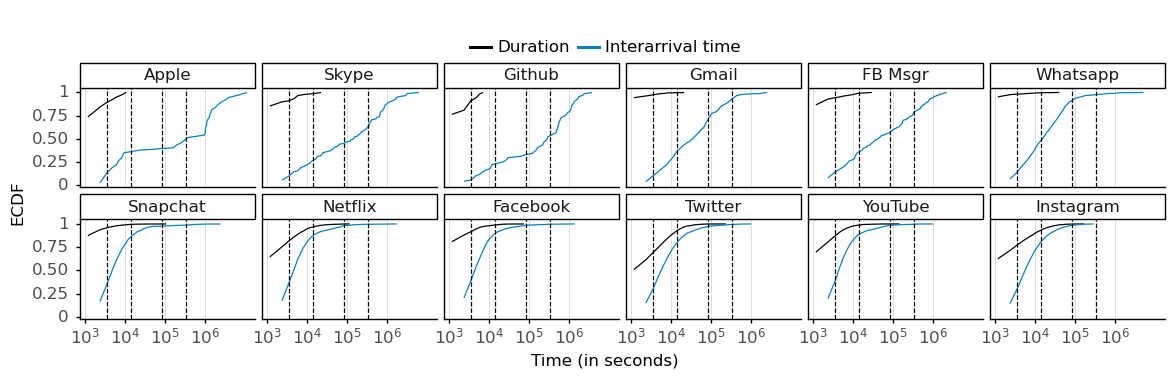

<ggplot: (311683578)>

In [242]:
dummy_df = duration_cdf_df.loc[:1, :].copy()
dummy_df.loc[0, 'dummy'] = '0'
dummy_df.loc[1, 'dummy'] = '1'

marker_df = pd.DataFrame({
    'sec': [60*60, 60*60*4, 60*60*24, 60*60*24*4],
    'y': [1, 1, 1, 1],
    'text': ['1 hour', '4 hours', '1 day', '4 days']
})

plt = ggplot(median_cdf_df) +\
    geom_line(aes(x='duration', y='cdf'), data=duration_cdf_df, color='black') +\
    geom_line(aes(x='ia', y='cdf'), data=ia_cdf_df, color='#0280c9') +\
    geom_line(aes(x='duration', y='cdf', color='dummy'), data=dummy_df) +\
    scale_x_log10(breaks=[1000, 10000, 100000, 1000000], labels=lambda l: list(map(lambda x: '$10^{}$'.format(int(np.log10(x))), l))) +\
    geom_vline(aes(xintercept='sec'), data=marker_df, linetype='--') +\
    facet_wrap(facets='vendor_cat', nrow=2) +\
    ylab('ECDF') +\
    xlab('Time (in seconds)') +\
    scale_color_manual(['black', '#0280c9'], labels=['Duration', 'Interarrival time']) +\
    guides(color=guide_legend(title='')) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    theme(figure_size=(14, 3),
          axis_text_y=element_text(margin={'r': 5}),
          panel_grid_major_x=element_line(size=0.7, color="gainsboro"),
          text=element_text(size=12),
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          legend_position='top')

plt.save('plots/failure_duration_ia_cdf.pdf', limitsize=None)
plt

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 3 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/failure_mean_peak_cdf.pdf
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only 

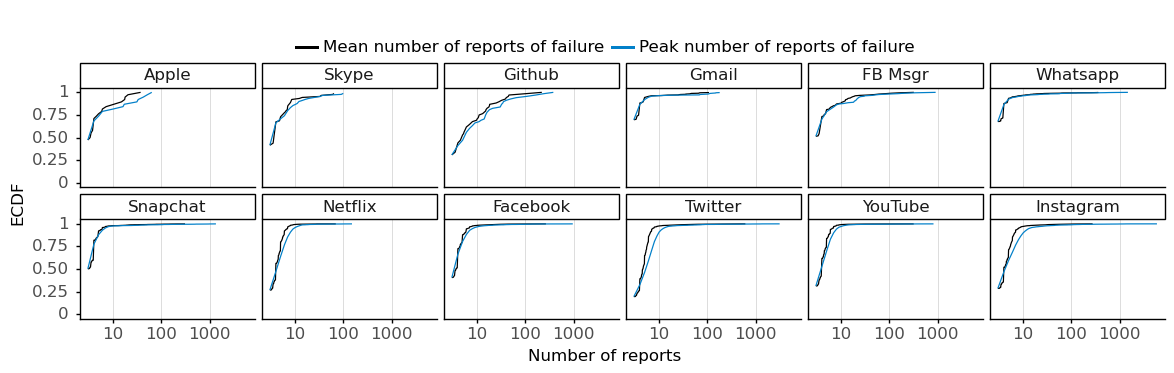

<ggplot: (314657497)>

In [243]:
dummy_df = mean_cdf_df.loc[:1, :].copy()
dummy_df.loc[0, 'dummy'] = '0'
dummy_df.loc[1, 'dummy'] = '1'

plt = ggplot(median_cdf_df) +\
    geom_line(aes(x='mean', y='cdf'), data=mean_cdf_df, color='black') +\
    geom_line(aes(x='peak', y='cdf'), data=peak_cdf_df, color='#0280c9') +\
    geom_line(aes(x='mean', y='cdf', color='dummy'), data=dummy_df) +\
    scale_x_log10() +\
    scale_y_continuous(limits=[0, 1]) +\
    facet_wrap(facets='vendor_cat', nrow=2) +\
    ylab('ECDF') +\
    xlab('Number of reports') +\
    scale_color_manual(['black', '#0280c9'], labels=['Mean number of reports of failure', 'Peak number of reports of failure']) +\
    guides(color=guide_legend(title='')) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    theme(figure_size=(14, 3),
          axis_text_y=element_text(margin={'r': 5}),
          panel_grid_major_x=element_line(size=0.7, color="gainsboro"),
          text=element_text(size=12),
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          legend_position='top')

plt.save('plots/failure_mean_peak_cdf.pdf', limitsize=None)
plt

In [246]:
filtered_failure_df['parsed_start_time'] = pd.to_datetime(filtered_failure_df['start_time'], unit='s')
precovid_failure_df = filtered_failure_df[(filtered_failure_df['parsed_start_time'].dt.year == 2019)
                                 & (filtered_failure_df['parsed_start_time'].dt.month >= 4)
                                 & (filtered_failure_df['parsed_start_time'].dt.month <= 8)].reset_index(drop=True)
covid_failure_df = filtered_failure_df[(filtered_failure_df['parsed_start_time'].dt.year == 2020)
                                 & (filtered_failure_df['parsed_start_time'].dt.month >= 4)
                                 & (filtered_failure_df['parsed_start_time'].dt.month <= 8)].reset_index(drop=True)

In [247]:
def compute_ia(partial_df):
    sorted_partial_df = partial_df.sort_values('start_time').reset_index(drop=True)
    ia_arr = sorted_partial_df['start_time'].values - np.roll(sorted_partial_df['start_time'].values, 1)
    partial_ia_df = pd.DataFrame({'ia': ia_arr[1:], 'count':1, 'vendor_cat': partial_df.loc[0, 'vendor_cat']})
    return partial_ia_df

precovid_ia_partial_df_list = []
covid_ia_partial_df_list = []

for vendor in precovid_failure_df['vendor_cat'].unique():
    precovid_partial_df = precovid_failure_df[precovid_failure_df['vendor_cat'] == vendor].reset_index(drop=True)
    covid_partial_df = covid_failure_df[covid_failure_df['vendor_cat'] == vendor].reset_index(drop=True)
    
    # Compute interarrival time
    precovid_ia = compute_ia(precovid_partial_df)
    covid_ia = compute_ia(covid_partial_df)
    
    precovid_ia_partial_df_list.append(precovid_ia)
    covid_ia_partial_df_list.append(covid_ia)

precovid_ia_df = pd.concat(precovid_ia_partial_df_list)
covid_ia_df = pd.concat(covid_ia_partial_df_list)

In [249]:
precovid_ia_quantiles = precovid_ia_df.groupby('vendor_cat')['ia'].quantile([0.50, 0.95]).reset_index().sort_values('ia').pivot(index='vendor_cat', columns='level_1')
covid_ia_quantiles = covid_ia_df.groupby('vendor_cat')['ia'].quantile([0.50, 0.95]).reset_index().sort_values('ia').pivot(index='vendor_cat', columns='level_1')
# precovid_ia_quantiles

In [250]:
precovid_duration_quantiles = precovid_failure_df.groupby('vendor_cat')['duration'].quantile([0.50, 0.95]).reset_index().sort_values('duration').pivot(index='vendor_cat', columns='level_1')
covid_duration_quantiles = covid_failure_df.groupby('vendor_cat')['duration'].quantile([0.50, 0.95]).reset_index().sort_values('duration').pivot(index='vendor_cat', columns='level_1')
covid_table = precovid_duration_quantiles.join(precovid_ia_quantiles).join(covid_duration_quantiles, rsuffix='_covid').join(covid_ia_quantiles, rsuffix='_covid') / 3600
covid_table

duration                   ia             duration_covid  \
level_1         0.50      0.95       0.50        0.95           0.50   
vendor_cat                                                             
Apple       0.333333  2.500000  98.000000  560.033333       0.500000   
Skype       0.333333  4.633333  99.333333  416.800000       0.333333   
Github      0.333333  1.000000  60.666667  308.600000       1.000000   
Gmail       0.333333  0.666667   5.000000   62.333333       0.333333   
FB Msgr     0.333333  1.200000   5.666667  186.200000       0.333333   
Whatsapp    0.333333  0.666667   4.333333   26.200000       0.333333   
Snapchat    0.333333  1.333333   1.333333    6.666667       0.333333   
Netflix     0.333333  3.416667   1.333333    8.333333       0.333333   
Facebook    0.333333  2.000000   1.333333    5.000000       0.333333   
Twitter     0.666667  5.666667   1.666667   10.666667       0.333333   
YouTube     0.333333  2.333333   1.333333    6.333333       0.333333   
Instagram   0.333333  6.000000   2.000000    8.633333       0.333333   

                        ia_covid               
level_1         0.95        0.50         0.95  
vendor_cat                                     
Apple       0.650000  899.666667   899.666667  
Skype       1.483333  178.666667  1070.333333  
Github      1.666667  158.333333   646.066667  
Gmail       2.000000   26.666667   583.733333  
FB Msgr     0.533333   11.000000   221.350000  
Whatsapp    0.666667   11.166667   376.150000  
Snapchat    1.333333    1.666667   126.500000  
Netflix     2.766667    2.000000    65.916667  
Facebook    1.266667    1.666667    69.566667  
Twitter     7.866667    5.000000    92.550000  
YouTube     1.666667    2.000000    44.700000  
Instagram   3.333333    3.000000    29.733333

In [251]:
print(covid_table.to_latex(float_format="%.1f"))

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{duration} & \multicolumn{2}{l}{ia} & \multicolumn{2}{l}{duration\_covid} & \multicolumn{2}{l}{ia\_covid} \\
level\_1 &     0.50 & 0.95 & 0.50 &  0.95 &           0.50 & 0.95 &     0.50 &   0.95 \\
vendor\_cat &          &      &      &       &                &      &          &        \\
\midrule
Apple      &      0.3 &  2.5 & 98.0 & 560.0 &            0.5 &  0.7 &    899.7 &  899.7 \\
Skype      &      0.3 &  4.6 & 99.3 & 416.8 &            0.3 &  1.5 &    178.7 & 1070.3 \\
Github     &      0.3 &  1.0 & 60.7 & 308.6 &            1.0 &  1.7 &    158.3 &  646.1 \\
Gmail      &      0.3 &  0.7 &  5.0 &  62.3 &            0.3 &  2.0 &     26.7 &  583.7 \\
FB Msgr    &      0.3 &  1.2 &  5.7 & 186.2 &            0.3 &  0.5 &     11.0 &  221.3 \\
Whatsapp   &      0.3 &  0.7 &  4.3 &  26.2 &            0.3 &  0.7 &     11.2 &  376.1 \\
Snapchat   &      0.3 &  1.3 &  1.3 &   6.7 &            0.3 &  1.3 &      1.7 &  126.5 \\
Netfl